# Run the multi-epoch deconvolution

Deconvolve all data simultaneously.

By [Martin Millon](https://martin-millon.gitlab.io), February 2023.

In [1]:
#For access outside the notebook with nbparametrise
theta_E = 0.5
lambda_scales = 1.0
lambda_hf = 1.0
scene = 'SNIa'

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os, glob

from copy import deepcopy

from starred.deconvolution.deconvolution import setup_model
from starred.deconvolution.loss import Prior, Loss
from starred.deconvolution.parameters import ParametersDeconv
from starred.optim.optimization import Optimizer
from starred.optim.inference_base import FisherCovariance
from starred.utils.generic_utils import Downsample
from starred.procedures.deconvolution_routines import multi_steps_deconvolution
from starred.plots.plot_function import plot_deconvolution, plot_loss, view_deconv_model
import pickle as pkl 

import astropy.io.fits as fits 
import json

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [3]:
# Parameters
epochs_index = None #None to take them all 
n_iter = 500

if 'SNIa' in scene: 
    regularize_pts_source = False
    subsampling_factor = 2
    update_lambda_pts_source = False
    lambda_pts_source = 0.
elif 'lensed_quasar' in scene:
    regularize_pts_source = True
    update_lambda_pts_source = True
    subsampling_factor = 3
    lambda_pts_source = 0.5 * lambda_scales

lambda_positivity_bkg = 0. #positivity constraint on the background
lambda_positivity_ps = 1000. #positivity constraint on the point source
regularize_full_model = False
convolution_method = 'scipy'
method_noise_psf = 'MC'

#PSF model 
psf_sim_name = 'defaultMCupsampling%i_scipy_barycenter_2.00_2.00'%subsampling_factor
instrument = 'WFI-time-series-2M1134'

#Select simulation
if scene == 'lensed_quasar':
    M = 4 # point sources
    sim_input_name = 'mock_lensed_quasar_exptime30'
    folder = './output/test_lensedQSO'
    psf_folder = './output/test_lensedQSO/%s/WFI-time-series-2M1134/output_PSF/%s'%(sim_input_name, psf_sim_name) #We can reuse PSF reconstruction for the SNIa simulation if we want
elif scene == 'SNIa':
    M = 1 # point sources 
    sim_input_name = 'mock_SNIa_exptime30'
    folder = './output/test_SNIa' 
    psf_folder = './output/test_SNIa/%s/WFI-time-series-2M1134/output_PSF/%s'%(sim_input_name, psf_sim_name)

blanck_epoch = 30
nepoch = 20
nexposure = 2 #exposure per epoch

#Generate the output paths: 
sim_folder = os.path.join(folder, sim_input_name, instrument)

epochs = sorted(glob.glob(os.path.join(sim_folder, 'epoch*'))) 
if not epochs_index is None : 
    epochs = [ epochs[i] for i in range(len(epochs)) if i in epochs_index]

print('I found %i epochs !'%len(epochs))


I found 50 epochs !


### Retrieve the data

In [4]:
# Retrieving data
data_vec = [] 
s_vec = [] 
fpsf_vec = [] 
sigma_2_vec = [] 

for epoch in epochs:
    epoch_basename = os.path.basename(epoch)
    psf_path = os.path.join(psf_folder, epoch_basename)
    data_path = os.path.join(epoch, 'theta_E_%2.2f'%theta_E)
    file_paths = sorted(glob.glob(os.path.join(data_path, 'lens*_skysub.fits')))
    data = np.array([fits.open(f)[0].data for f in file_paths]) 
    n_images, n_pix, _ = np.shape(data)

    im_size = np.shape(data)[1]
    im_size_up = im_size * subsampling_factor

    # Retrieving the narrow PSF 
    file_paths = sorted(glob.glob(os.path.join(psf_path, 'narrow_PSF*.fits')))
    if len(file_paths) == 0: 
        raise RuntimeError('Narrow PSF files not found')
    
    s = np.array([fits.open(f)[0].data for f in file_paths])
    s = np.repeat(s[np.newaxis, :, :], n_images, axis=0).reshape(n_images, n_pix*subsampling_factor,n_pix*subsampling_factor)

    # Retrieving the full PSF 
    file_paths = sorted(glob.glob(os.path.join(psf_path, 'full_PSF.fits')))
    if len(file_paths) == 0: 
        raise RuntimeError('Full PSF files not found')
    
    fpsf = np.array([fits.open(f)[0].data for f in file_paths])
    fpsf = np.repeat(fpsf[np.newaxis, :, :], n_images, axis=0).reshape(n_images, n_pix*subsampling_factor,n_pix*subsampling_factor)

    # Retrieving noise maps
    file_paths = sorted(glob.glob(os.path.join(data_path, 'sigma*.fits')))
    sigma_2 = np.array([fits.open(f)[0].data for f in file_paths]) ** 2

    for i in range(n_images):
        data_vec.append(data[i, :, :])
        s_vec.append(s[i, :, :])
        sigma_2_vec.append(sigma_2[i, :, :])
        full_psf = Downsample(fpsf[i,:,:], subsampling_factor) #Dowsample the PSF to bring it back to data resolution
        full_psf /= np.sum(full_psf) # Renormalise the PSF
        fpsf_vec.append(full_psf)

data = np.asarray(data_vec)
sigma_2 = np.asarray(sigma_2_vec)
s = np.asarray(s_vec)
fpsf = np.asarray(fpsf_vec)
n_images, n_pix, _ = np.shape(data)

print('Data shape :', np.shape(data)) 
print('Noise maps shape :', np.shape(sigma_2))
print('Narrow PSF shape :', np.shape(s))
print('Full PSF shape :', np.shape(fpsf))
print('Total number of images to process :', n_images)

#Renormalise your data and the noise maps by the max of the first image. Works better when using adabelief
norm = data[0].max() / 100.
data /= norm
sigma_2 /= norm**2 



Data shape : (100, 64, 64)
Noise maps shape : (100, 64, 64)
Narrow PSF shape : (100, 128, 128)
Full PSF shape : (100, 64, 64)
Total number of images to process : 100


# Initialise parameters 

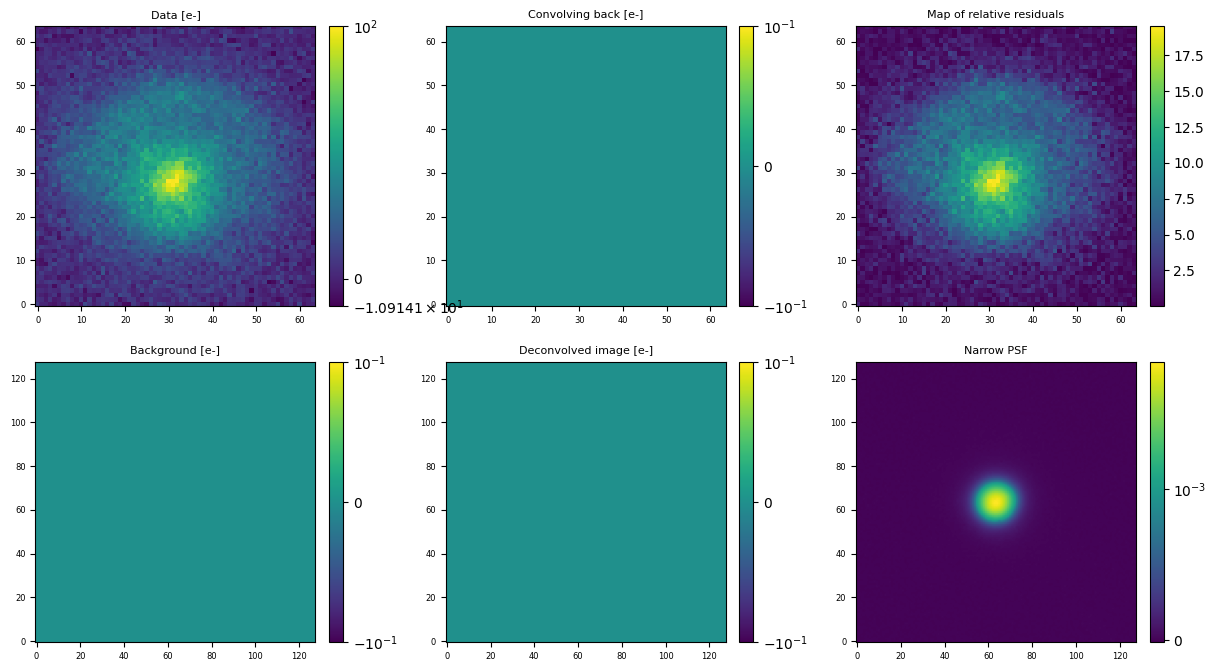

In [5]:
# Parameter initialization
with open(os.path.join(epochs[0], 'theta_E_%2.2f'%theta_E, 'info_exp0.pkl'), 'rb') as f:
    source_amp, amps, mag, mag_lensed, lcs, SNR, shift_vecx, shift_vecy, ps_ra, ps_dec = pkl.load(f)

pixel_size = 0.21
initial_c_x = ps_ra/pixel_size 
initial_c_y = ps_dec/pixel_size 
M = len(initial_c_x)
if 'SNIa' in scene:
    initial_a = 6*np.array([data[i,:,:].max() for i in range(n_images) for j in range(M)]) 
else: 
    initial_a = 0*np.array([data[i,:,:].max() for i in range(n_images) for j in range(M)]) 

# Getting the model and kwargs:
model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data, sigma_2, s, initial_c_x, initial_c_y, subsampling_factor, 
                                                                       initial_a = initial_a, astrometric_bound = 5, dithering_bound = 10,
                                                                      convolution_method = 'fft', N_sersic=0)

#fixing point source photometry before SNIa explosion
if scene == 'SNIa' : 
    a_fixed = np.asarray([0.]* (blanck_epoch+1) * nexposure + [np.nan]*(nepoch-1)*nexposure)
    kwargs_fixed['kwargs_analytic']['a'] = a_fixed
    kwargs_init['kwargs_analytic']['a'][0:(blanck_epoch+1) *nexposure] = 0.

parameters = ParametersDeconv(kwargs_init, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)


#define wide prior for the point source position
prior = Prior(prior_analytic=[['c_x',initial_c_x,1.], ['c_y',initial_c_y, 1.]], prior_background=None)

#view intitial conditions 
fig_preview = plot_deconvolution(model, data, sigma_2, s, kwargs_init, epoch = 0, units='e-')
plt.show()


# Setup the fitting sequence
Here we will ensure the possible convergence, favoring the best possible accuracy at a price of little bit more computing time. 

Step 1, fixing : ['pts-source-astrometry']


optax.adabelief: 100%|██████████| 500/500 [03:22<00:00,  2.47it/s]


Step 1/3 took 202 seconds
Kwargs partial at step 1/3 {'kwargs_analytic': {'a': Array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  2.4230182 ,  2.4773204 

optax.adabelief: 100%|██████████| 500/500 [03:25<00:00,  2.44it/s]


Step 2/3 took 205 seconds
Kwargs partial at step 2/3 {'kwargs_analytic': {'a': Array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  4.4530263,  4.6872373, 10.704565 ,
       10.607621 , 14.632867 , 14.604438 , 13.8150

optax.adabelief: 100%|██████████| 500/500 [03:18<00:00,  2.52it/s]


Step 3/3 took 198 seconds
Kwargs partial at step 3/3 {'kwargs_analytic': {'a': Array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  4.4373045,  4.6687975, 10.741116 ,
       10.621806 , 14.642716 , 14.579749 , 13.7416

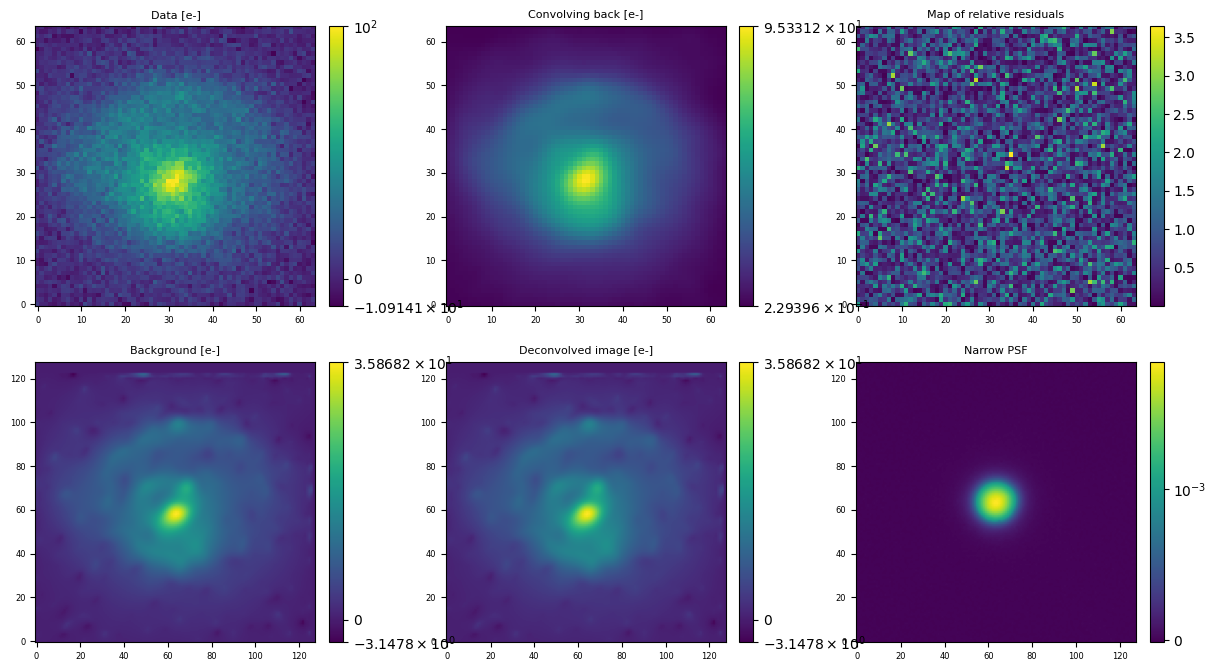

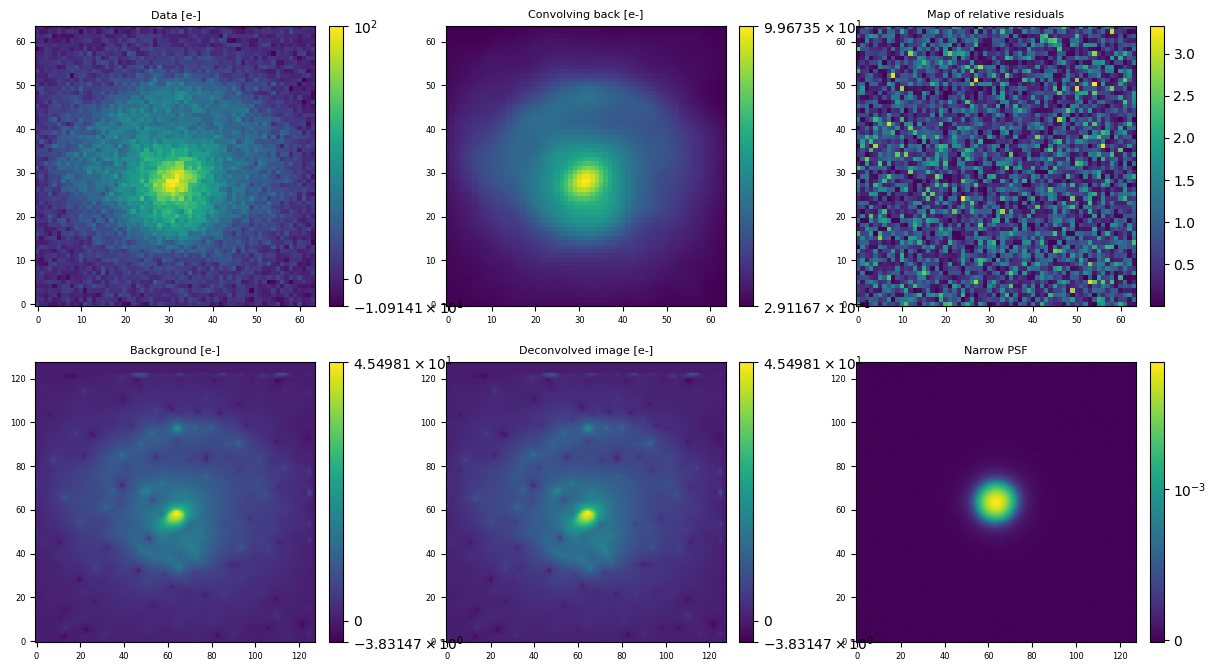

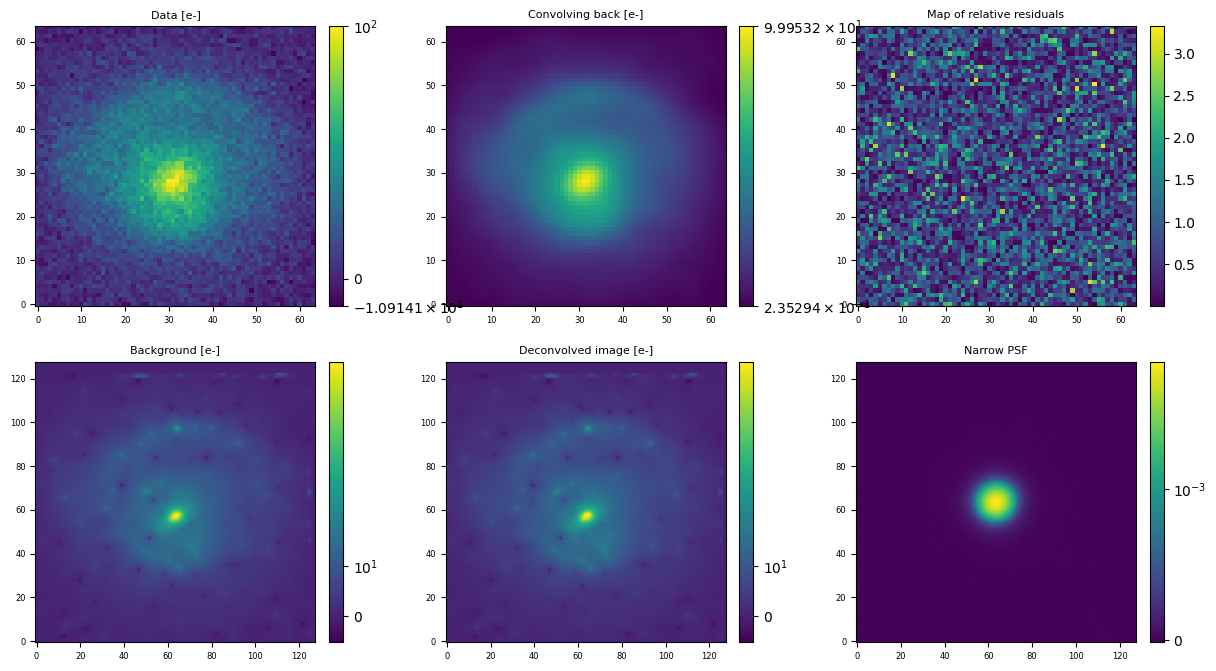

In [6]:
#Selecting the fixed components at each step, the rest is free. Format [['pts-source-astrometry','pts-source-photometry','background'],['pts-source-astrometry','pts-source-photometry'], ...]
fitting_sequence = [
                    ['pts-source-astrometry'], #step 1 : raise background, keeping astrometry fixed
                    #['background'], #step 2 : keep background fix, adjust astrometry
                    [], #step 3 : release everything
                    [], #step 4 : release everything
        ]
    
#We use l-bfgs-b when the background is fixed (small number of free parameters) and adabelief otherwise
# optim_list = ['adabelief','l-bfgs-b','adabelief']
optim_list = ['adabelief','adabelief', 'adabelief']
    
kwargs_optax1 = {
        'max_iterations': n_iter, 'min_iterations': None,
        'init_learning_rate': 1e-1, 'schedule_learning_rate': True,
        'restart_from_init': True, 'stop_at_loss_increase': False,
        'progress_bar': True, 'return_param_history': True
    }

kwargs_optax2 = {
        'max_iterations': n_iter, 'min_iterations': None,
        'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
        'restart_from_init': True, 'stop_at_loss_increase': False,
        'progress_bar': True, 'return_param_history': True
    }

kwargs_optax3 = {
        'max_iterations': n_iter, 'min_iterations': None,
        'init_learning_rate': 5e-3, 'schedule_learning_rate': True,
        'restart_from_init': True, 'stop_at_loss_increase': False,
        'progress_bar': True, 'return_param_history': True
    }

kwargs_optim_list = [kwargs_optax1, kwargs_optax2, kwargs_optax3] 
prior_list=[None, None,None]

if scene == 'lensed_quasar' and update_lambda_pts_source: 
    #we add one more if lambda_pts_source need to be updated (not stricly necessary but better be safe)
    fitting_sequence.append([])
    kwargs_optim_list.append(kwargs_optax3)
    prior_list.append(None)
    optim_list.append('adabelief')

#we apply our astrometric prior nonly when the point sources are free (i.e. not for the second step)


model, parameters, loss, kwargs_partial_list, fig_list, LogL_list, loss_history_list = multi_steps_deconvolution(data, model, parameters, sigma_2, s, subsampling_factor,
                                                                                    fitting_sequence = fitting_sequence,
                                                                                    optim_list = optim_list, kwargs_optim_list = kwargs_optim_list,
                                                                                    lambda_scales = lambda_scales, lambda_hf =lambda_hf, lambda_positivity_bkg = lambda_positivity_bkg, 
                                                                                    lambda_positivity_ps=lambda_positivity_ps, lambda_pts_source = lambda_pts_source,
                                                                                    prior_list = prior_list, update_lambda_pts_source = update_lambda_pts_source,
                                                                                    noise_propagation = 'MC')
plt.show()

Step 1, optimiser adabelief
Step 2, optimiser adabelief
Step 3, optimiser adabelief


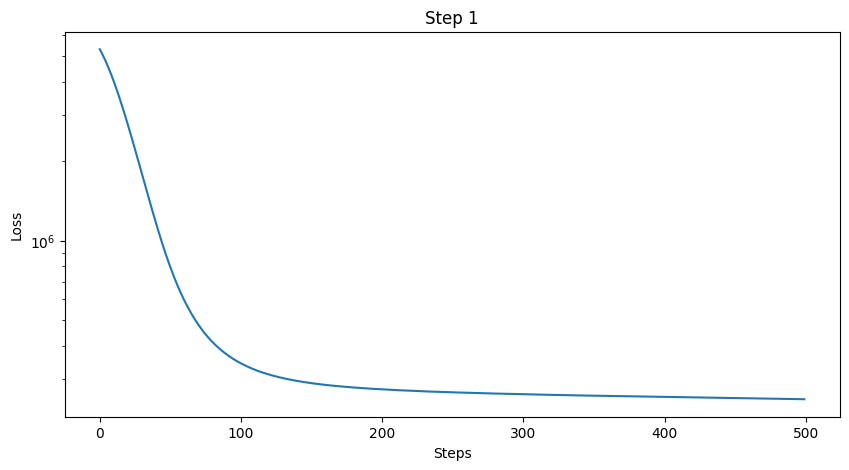

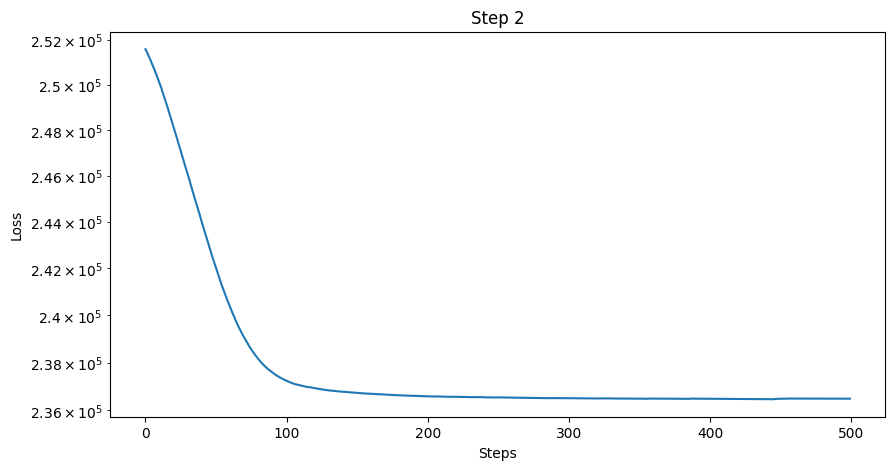

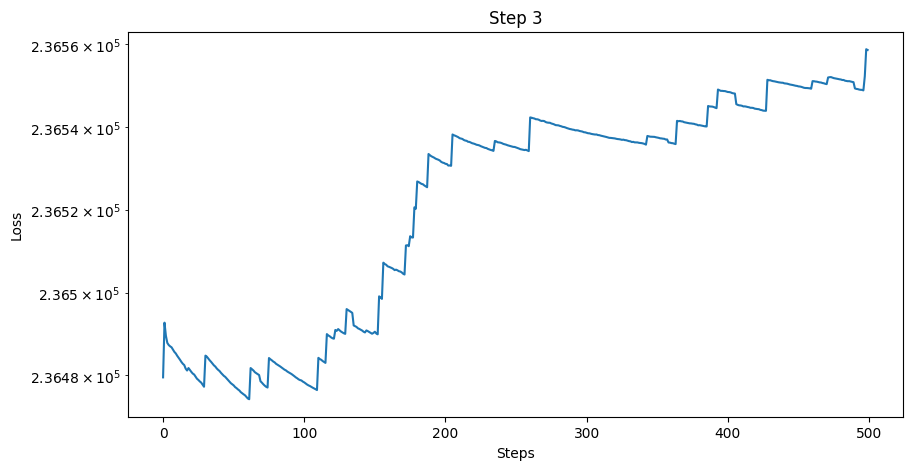

In [7]:
kwargs_final = kwargs_partial_list[-1]
lambda_pts_source_new = deepcopy(loss._lambda_pts_source)
if lambda_pts_source_new != lambda_pts_source:
    print(f'Pts regularisation strenght has been changed from {lambda_pts_source} to {lambda_pts_source_new}')
    lpts2 = deepcopy(loss.update_lambda_pts_source(kwargs_final))
    print(f'New one would be {lpts2}')
else:
    lpts2 = lambda_pts_source

suf=''
if regularize_pts_source: 
    if update_lambda_pts_source: 
        suf = '_autoregpts'
    else: 
        suf = '_regpts%2.2f'%lambda_pts_source_new

outpath = os.path.join(sim_folder, 'output_lambda%2.2f-%2.2f_pos100_upsample%i%s'%(lambda_scales, lambda_hf, subsampling_factor, suf), 'theta_E_%2.2f'%theta_E)
if not os.path.exists(outpath):
    os.makedirs(outpath,exist_ok=True)
    
for i in range(len(loss_history_list)):
    print('Step %i, optimiser %s'%(i+1, optim_list[i]))
    fig = plot_loss(loss_history=loss_history_list[i], title = 'Step %i'%(i+1))
    fig.savefig(os.path.join(outpath,'loss_step%i.pdf'%i))
    fig_list[i].savefig(os.path.join(outpath,'fig_step%i.pdf'%i))

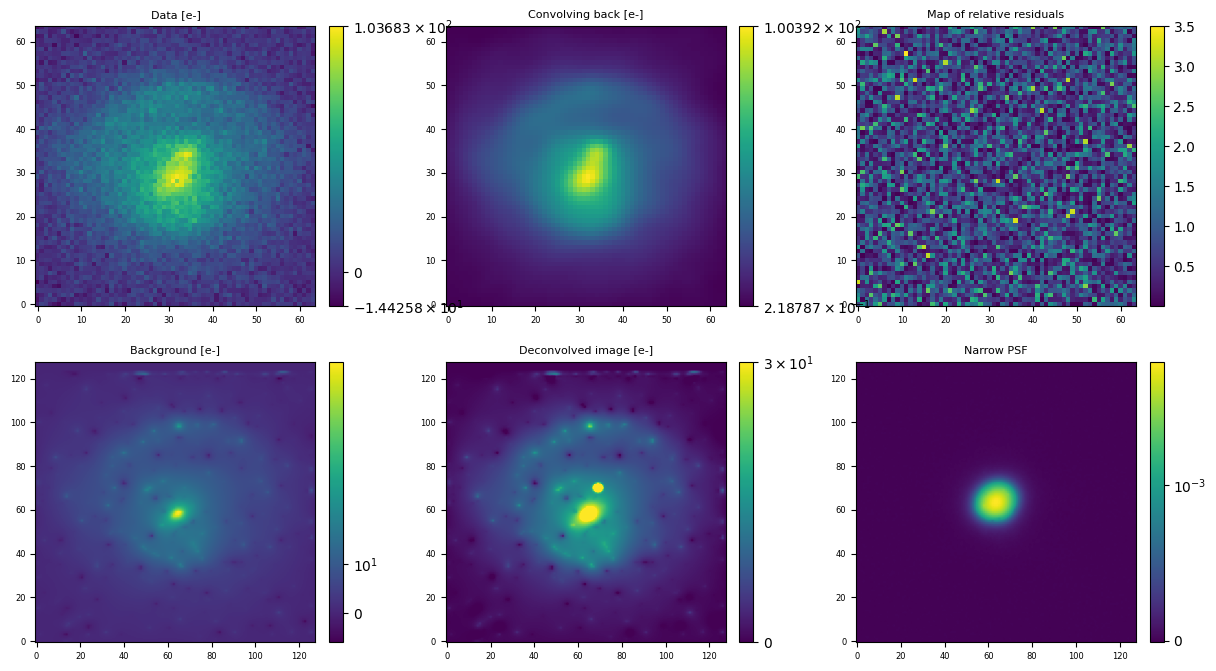

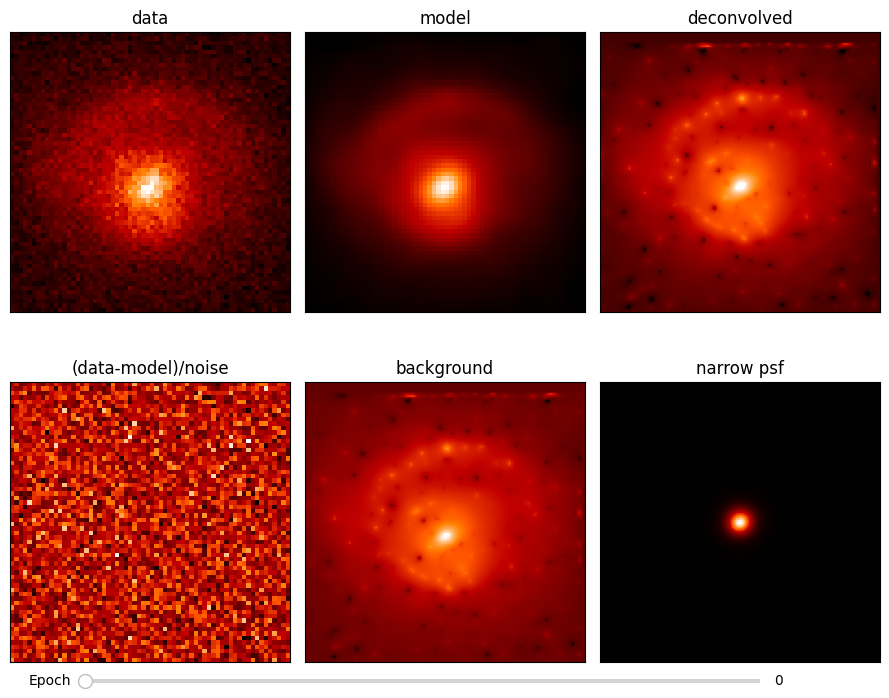

In [8]:

#plot final model with adjusted color cuts
cut_dict = {
            'linthresh':[5e2,5e2,None,5e1,5e1,1e-3],
            'vmin':[None,None, None, None, 0, None],
            'vmax':[None, None, None, None, 30, None],
        }

fig = plot_deconvolution(model, data, sigma_2, s, kwargs_final, epoch = 75, units='e-', cut_dict=cut_dict)
fig.savefig(os.path.join(outpath,'summary_fig.pdf'))
view_deconv_model(model, kwargs_final, data, sigma_2)

Step 1, optimiser adabelief
Step 2, optimiser adabelief
Step 3, optimiser adabelief


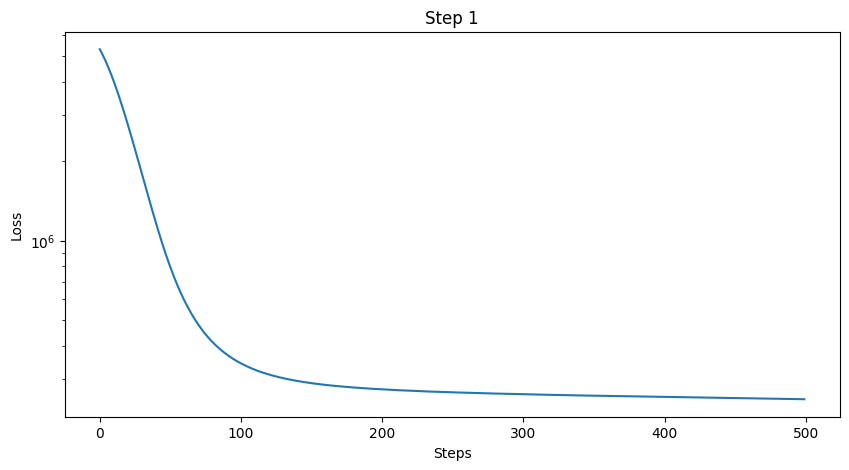

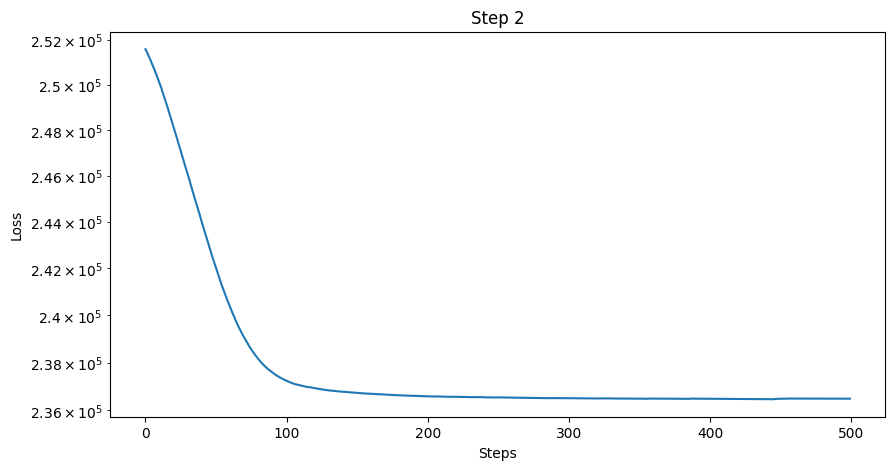

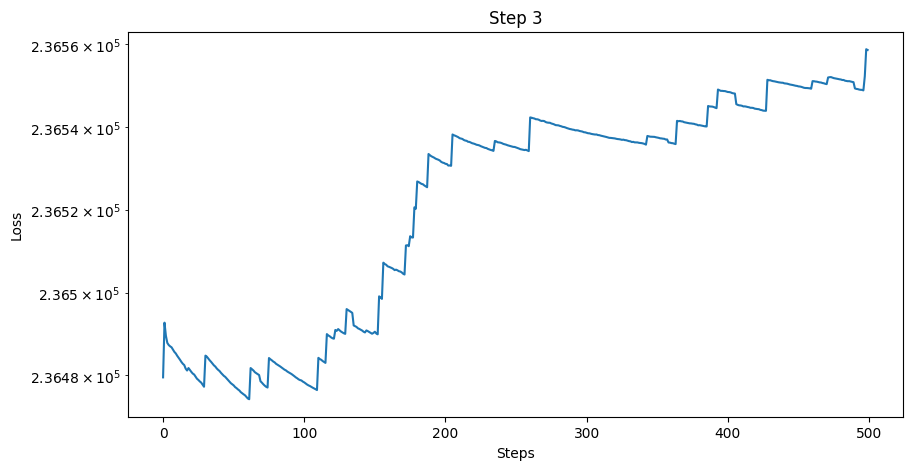

In [9]:
for i in range(len(loss_history_list)):
    print('Step %i, optimiser %s'%(i+1, optim_list[i]))
    fig = plot_loss(loss_history=loss_history_list[i], title = 'Step %i'%(i+1))

In [10]:
if not os.path.isdir(outpath):
    os.makedirs(outpath, exist_ok= True)

model.export(outpath, kwargs_final, data, sigma_2, epoch=1, format='fits', norm=norm)
model.dump(os.path.join(outpath, 'model.hdf5'), kwargs_final, data, sigma_2, save_output_level=4, format='hdf5')



In [11]:
def convert_to_numpy_array(kwargs):
    new_dic = {}
    for k in kwargs.keys():
        dic_temp={}
        for j in kwargs[k].keys():
            dic_temp[j]=deepcopy(np.asarray(kwargs[k][j]).tolist())
        new_dic[k] = deepcopy(dic_temp)
    
    return new_dic

with open(os.path.join(outpath, 'kwargs_final.json'), 'w') as f: 
    json.dump(convert_to_numpy_array(kwargs_final), f)

with open(os.path.join(outpath, 'kwargs_fixed.json'), 'w') as f: 
    json.dump(convert_to_numpy_array(kwargs_fixed), f)

with open(os.path.join(outpath, 'kwargs_up.json'), 'w') as f: 
    json.dump(convert_to_numpy_array(kwargs_up), f)

with open(os.path.join(outpath, 'kwargs_down.json'), 'w') as f: 
    json.dump(convert_to_numpy_array(kwargs_down), f)

chi2 =  -2 * loss._log_likelihood_chi2(kwargs_final) / (im_size ** 2)
Logl_regul =  loss._log_regul(kwargs_final)
Logl =  loss._log_likelihood(kwargs_final)
inv_loss = - loss.loss(parameters.kwargs2args(kwargs_final))

print('chi2 :', chi2)
print('Logl :', Logl)
print('Logl regul:', Logl_regul)
print('-Loss:', inv_loss )

info_dic =  {'chi2': float(chi2), 'Logl':float(Logl), 'Logl regul':float(Logl_regul), 'Inverse Loss':float(inv_loss), 'Norm':float(norm),
             'lambda_scales':float(lambda_scales), 'lambda_hf':float(lambda_hf), 'lambda_pts_source':float(lambda_pts_source_new), 'lambda_pts_source_next':float(lpts2)}

with open(os.path.join(outpath, 'info_dic.json'), 'w') as f: 
    json.dump(info_dic, f)

chi2 : 96.92876
Logl : -198510.1
Logl regul: -38048.59
-Loss: -236558.69


In [12]:
#Estimating photometric errors:
# We use standard PSF photometry error estimates from : 
#https://www.stsci.edu/files/live/sites/www/files/home/hst/documentation/_documents/wfpc2/wfpc2_ihb_cycle17.pdf
# Heyer, Biretta, et al. 2004, WFPC2 Instrument Handbook, Version 10.0, Chapter 6

sigma_WPFC = np.zeros((n_images, M))
for i in range(n_images): 
    sharpness = np.sum(fpsf[i, :, :] * fpsf[i, :, :])
    bkg_sigma2 = np.mean(sigma_2[i, im_size-5:, im_size-5] * norm**2)
    for j in range(M):
        flux = model.flux_at_epoch(kwargs_final, epoch=i)[j] * norm
        sigma_WPFC[i,j] = np.sqrt(flux + bkg_sigma2/sharpness)

sigmas = {'PSFshotnoiseWPFC':sigma_WPFC.tolist()}

# Estimating errors: from the covariance Matrix

We will reduce the dimensianility of the problem before computing the covariance matrix. We are fixing the background and ignore covariances between the point source and the background to avoid using to much memory. 

In [13]:
def get_args_errs(kwargs, kwargs_fixed, kwargs_up, kwargs_down, data, sigma_2, model, parameters, diagonal_only):        
    parameters = ParametersDeconv(kwargs_init=kwargs, 
                                  kwargs_fixed=kwargs_fixed, 
                                  kwargs_up=kwargs_up, 
                                  kwargs_down=kwargs_down)
    
    args = parameters.kwargs2args(kwargs)
    print(f"Reoptimising {len(args)} parameters.")

    loss = Loss(data, model, parameters, sigma_2, 
                regularization_terms='l1_starlet', 
                regularization_strength_hf=0., regularization_strength_scales=0) #remove the regularisation, since the background is fixed
    kwargs_optax_fast = {
        'max_iterations': 50, 'min_iterations': None,
        'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
        'restart_from_init': True, 'stop_at_loss_increase': False,
        'progress_bar': True, 'return_param_history': True
    }
    optim = Optimizer(loss, parameters, method='adabelief')
    optim.minimize(**kwargs_optax_fast)

    fish = FisherCovariance(parameters, optim, diagonal_only)
    fish.compute_fisher_information()
    k_errs = fish.get_kwargs_sigma()
    return k_errs

# we fixed all the parameters, except a_i, cx and cy, the amplitude of the SNIa after explosion and its position. 
# This reduces to 38 amplitudes and 2 centroids parameters. 
kwargs_fixed['kwargs_analytic']['dx']= kwargs_final['kwargs_analytic']['dx'].copy()
kwargs_fixed['kwargs_analytic']['dy']= kwargs_final['kwargs_analytic']['dy'].copy()
kwargs_fixed['kwargs_background']['h'] = kwargs_final['kwargs_background']['h'].copy()
kwargs_fixed['kwargs_background']['mean'] = kwargs_final['kwargs_background']['mean'].copy()
    
k_errs = get_args_errs(kwargs_final, kwargs_fixed, kwargs_up, kwargs_down, data, sigma_2, model, parameters, diagonal_only=False)
starred_err = k_errs['kwargs_analytic']['a'].reshape(n_images, M) * norm * model.scale
sigmas['STARRED'] = starred_err.tolist()

Reoptimising 40 parameters.


optax.adabelief: 100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


In [18]:
print(kwargs_final['kwargs_analytic']['a']* norm * model.scale)
print(sigmas['STARRED'])
print(sigmas['PSFshotnoiseWPFC'])

[   0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.         0.         0.         0.         0.
    0.         0.      1419.533   1493.5896  3436.178   3398.0098
 4684.3345  4664.191   4396.0674  4363.2075  3072.639   3098.3088
 1753.6855  1794.5887   983.7281  1033.4768   612.30396  668.9284
  520.3803   512.4753   660.71936  621.073    647.13434  681.39215
  659.0158   670.94586  666.4734   674.7199   674.2639   710.45013
  667.93384  666.46844  660.92706  684.6059   67

In [15]:
with open(os.path.join(outpath, 'sigmas_amps.json'), 'w') as f:   
        json.dump(sigmas, f)
